In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import datasets


#### question 1: Logistic Regression:

In [2]:
class LogisticRegression:
    
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self._weights = None

    def sigmoid(self, z):
        # Clip the values to avoid overflow in exp
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_of_samples, num_of_features = X.shape
        self._weights = np.zeros(num_of_features)
        
        # Gradient decsent
        for i in range(self.iterations):
            linear_model = np.dot(X , self._weights)
            y_pred = self.sigmoid(linear_model)
            gradient = np.dot(X.T , (y_pred - y)) / num_of_samples
            self._weights -= self.learning_rate * gradient     
            
    def predict(self, X):
        linear_model = np.dot(X , self._weights)
        y_pred = self.sigmoid(linear_model)
        return np.where(y_pred >= 0.5, 1, 0)
 
    def proba_predict(self, X):
        linear_model = np.dot(X, self._weights)
        return self.sigmoid(linear_model)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


#### question 2:
###### hey it takes maximum 1 minute

In [3]:
def preprocess_text(text):
    unwanted_words = ['to', 'is', 'are', 'a','an', 'the', 'and','on','for','as','not']
    #text = text.lower()
    text = text.lower().replace('subject: ', '')
    text = re.sub(r'[^\w\s]', '', text)
    words =  text.split()
    words = [word for word in words if word not in unwanted_words]
    return ' '.join(words)

df = pd.read_csv("spam_ham_dataset.csv")
df['text'] = df['text'].apply(preprocess_text)

# Convert text data into numerical features using "bag of words" method
vectorizer = CountVectorizer(max_features=1000)  
X = vectorizer.fit_transform(df['text']).toarray()

y = df['label_num'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Initialize and train the logistic regression model
model = LogisticRegression(learning_rate=0.01, iterations=1000)
model.fit(X_train, y_train)


score = model.score(X_test, y_test)
print(f"Score: {round(score,3)}")

# Print the weights vector
print("Weights vector:", [round(x,3) for x in model._weights])


Score: 0.945
Weights vector: [-0.044, -0.16, -0.124, -0.042, -0.035, -0.026, -0.039, -0.042, -0.014, -0.015, -0.019, -0.085, 0.066, -0.054, -0.077, 0.013, -0.035, -0.019, -0.024, -0.012, 0.003, -0.041, -0.018, -0.023, -0.018, -0.023, 0.01, -0.333, -0.247, 0.044, 0.121, -0.037, -0.013, -0.026, -0.011, 0.004, -0.029, -0.012, -0.034, -0.064, -0.025, -0.074, 0.018, -0.047, 0.007, 0.007, -0.002, 0.005, 0.026, 0.001, 0.003, 0.005, 0.017, -0.002, -0.004, 0.01, 0.002, 0.009, -0.001, 0.044, -0.009, 0.004, -0.004, 0.005, 0.013, 0.012, 0.004, 0.001, 0.077, 0.006, -0.006, 0.012, 0.044, -0.119, 0.023, 0.061, -0.025, -0.038, 0.014, 0.069, 0.055, -0.008, 0.018, -0.013, -0.024, 0.006, -0.043, 0.053, -0.019, 0.032, 0.015, -0.017, -0.006, -0.023, -0.065, -0.01, -0.016, -0.013, -0.01, -0.003, 0.056, 0.016, -0.012, -0.019, -0.004, -0.021, -0.02, -0.013, -0.043, -0.024, 0.015, 0.001, 0.011, 0.087, -0.011, -0.012, -0.012, -0.008, -0.026, 0.02, -0.122, 0.0, -0.046, -0.004, -0.003, -0.009, -0.084, -0.004, -0.

#### question 3:

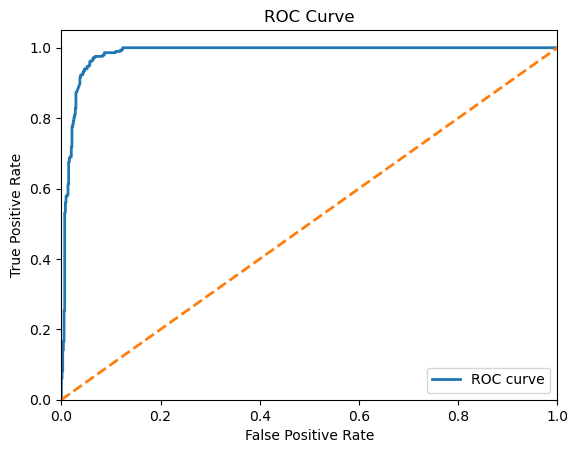

Best threshold is: 0.44


In [4]:
def ROC_curve(y_test, y_prob):
    false_positive_rate , true_positive_rate, thresholds = metrics.roc_curve(y_test, y_prob)
    
    #print(thresholds)
    plt.figure()
    
    plt.title(f'ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.plot(false_positive_rate, true_positive_rate, lw=2, label = 'ROC curve')
    plt.legend(loc="lower right")

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.show()
    
    return false_positive_rate, true_positive_rate, thresholds

y_prob = model.proba_predict(X_test)

fpr, tpr, thresholds = ROC_curve(y_test, y_prob)

youden_index = tpr - fpr
best_threshold_index = np.argmax(youden_index)
best_threshold = thresholds[best_threshold_index]
print(f"Best threshold is: {round(best_threshold,2)}")


#### question 4: Multiclass Logistic Regression

In [5]:
class MulticlassLogisticRegression(LogisticRegression):
    def __init__(self, learning_rate=0.01, iterations=1000):
        super().__init__(learning_rate, iterations)
        self._classes = None
        
        # a list that stores the logistic regression models for each class (one vs rest)
        self.models = []
        

    def fit(self, X, y):
        self._classes = np.unique(y)
        num_of_classes = len(self._classes)
        self.models = []

        for c in self._classes:
            model = LogisticRegression(learning_rate=self.learning_rate, iterations=self.iterations)
            binary_y = np.where(y == c, 1, 0)
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        y_prob = self.proba_predict(X)
        return np.argmax(y_prob, axis=1)

    def proba_predict(self, X):
        num_of_classes = len(self._classes)
        y_prob = np.zeros((X.shape[0], num_of_classes))
        
        for i, model in enumerate(self.models):
            y_prob[:, i] = model.proba_predict(X)
        
        return y_prob


In [6]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

X_train, X_test, y_train, y_test1 = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Polynomial features:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model = MulticlassLogisticRegression(learning_rate=0.01, iterations=1000)

model.fit(X_train_poly, y_train)

score = model.score(X_test_poly, y_test1)
print(f"Score: {round(score,3)}")

for class_name, model in zip(iris.target_names, model.models):
    print(f"class {class_name}, Weights vector:", [round(x,3) for x in model._weights])
    print("")


Score: 0.967
class setosa, Weights vector: [-0.779, -0.682, 0.741, -1.023, -0.96, -0.168, -0.201, 0.098, 0.12, -0.259, -0.102, -0.163, 0.127, 0.109, 0.012]

class versicolor, Weights vector: [0.559, 0.233, -0.441, 0.138, -0.056, -0.0, 0.191, -0.307, -0.336, 0.163, 0.294, 0.371, -0.585, -0.634, -0.733]

class virginica, Weights vector: [-0.804, 0.448, -0.053, 0.726, 0.895, -0.152, 0.072, -0.017, -0.002, -0.394, 0.063, -0.011, 0.073, 0.14, 0.29]

